In [ ]:
import random
import pandas as pd
import math
import copy
import matplotlib
import matplotlib.pyplot as plt

# Признаки и датасет

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Feature Selection** производили так:
*   Отбросили те признаки, которые априори не могут быть известны до полета и скачали датасет в .csv
*   Убрали пропуски в данных
*   Преобразовали категориальные признаки
*   Посмотрели корреляцию и графики, отбросили некоторые признаки
*   Затем произвели нормализацию признаков (Z-нормализация)

**Про категориальные:**
В датасете очень много категориальных признаков, с которыми линейная регрессия работает не очень. Пробовали кодировать one-hot-encoding и по количеству объектов с данным значением категориального признака. В итоге остановились на one-hot-encoding с несколькими из категориальных признаков.

# Предобработка (без нормализации)

In [ ]:
data = pd.read_csv("drive/MyDrive/97729915_T_ONTIME_REPORTING.csv")
data = data.iloc[:, :-1]
data.sample(10)

,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_STATE_NM,DEST_AIRPORT_ID,DEST_STATE_NM,CRS_DEP_TIME,DEP_DELAY,CRS_ELAPSED_TIME,DISTANCE
579965,31,4,OO,14524,RIC,Virginia,13930,Illinois,1030,NaN,141.0,642.0
575813,31,4,WN,13232,MDW,Illinois,10397,Georgia,710,NaN,110.0,591.0
207832,11,5,AA,12266,IAH,Texas,11298,Texas,631,-4.0,83.0,224.0
187377,10,4,WN,14107,PHX,Arizona,12191,Texas,715,-2.0,145.0,1020.0
409078,22,2,AA,14100,PHL,Pennsylvania,11278,Virginia,1639,-3.0,65.0,119.0
573466,31,4,HA,13830,OGG,Hawaii,12173,Hawaii,1553,-7.0,43.0,100.0
346165,19,6,UA,14893,SMF,California,13930,Illinois,632,53.0,237.0,1781.0
97862,6,7,WN,14893,SMF,California,12892,California,1825,36.0,85.0,373.0
293567,16,3,AA,14100,PHL,Pennsylvania,13487,Minnesota,1809,-8.0,189.0,980.0
277863,15,2,YX,13930,ORD,Illinois,13198,Missouri,1015,-9.0,101.0,403.0


In [ ]:
print(data.shape)
data = data.dropna()
data = data.drop_duplicates()
data.shape

(583985, 12)


(567629, 12)

In [ ]:
data.isna().sum(axis=0)

DAY_OF_MONTH         0
DAY_OF_WEEK          0
OP_UNIQUE_CARRIER    0
ORIGIN_AIRPORT_ID    0
ORIGIN               0
ORIGIN_STATE_NM      0
DEST_AIRPORT_ID      0
DEST_STATE_NM        0
CRS_DEP_TIME         0
DEP_DELAY            0
CRS_ELAPSED_TIME     0
DISTANCE             0
dtype: int64

In [ ]:
# Конвертируем время hhmm в минуты
time = data['CRS_DEP_TIME'].copy()
data['CRS_DEP_TIME'] = time % 100 + 60 * (time // 100)

In [ ]:
y = data['DEP_DELAY']
y = y.tolist()

#Изучение данных

(array([5.53794e+05, 1.14890e+04, 1.44300e+03, 3.61000e+02, 1.91000e+02,
        1.75000e+02, 1.02000e+02, 4.40000e+01, 2.50000e+01, 5.00000e+00]),
 array([ -47. ,  122.8,  292.6,  462.4,  632.2,  802. ,  971.8, 1141.6,
        1311.4, 1481.2, 1651. ]),
 <a list of 10 Patch objects>)

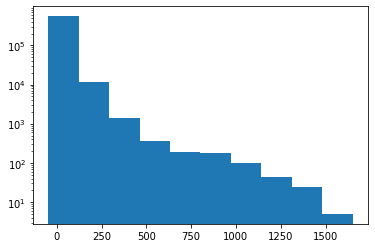

In [ ]:
plt.hist(data["DEP_DELAY"], log=True)

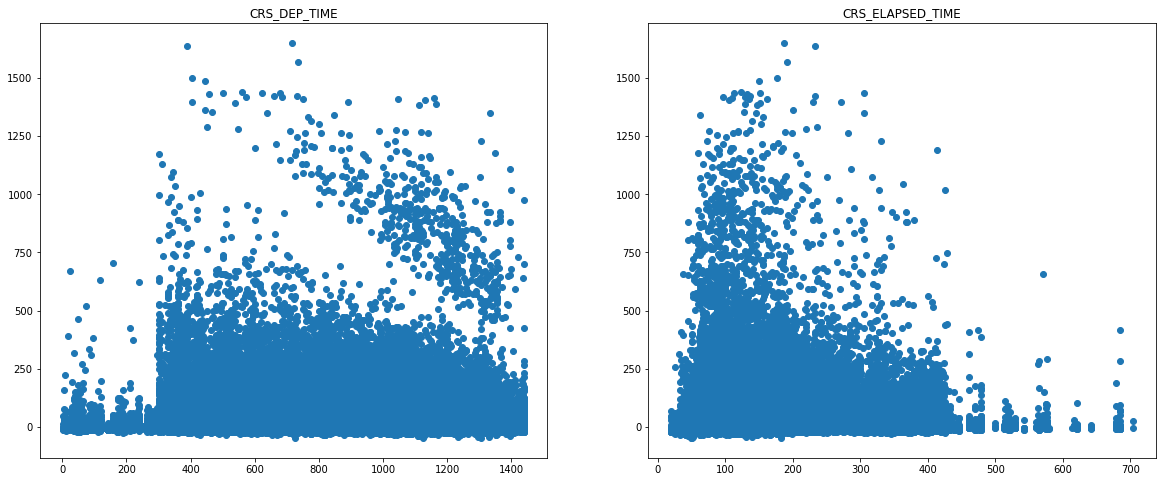

In [ ]:
numerical = ["CRS_DEP_TIME", 'CRS_ELAPSED_TIME']
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
for i in range(2):
    col_name = numerical[i]
    x_i = data[col_name]
    axs[i].scatter(x_i, y)
    axs[i].set_title(col_name)

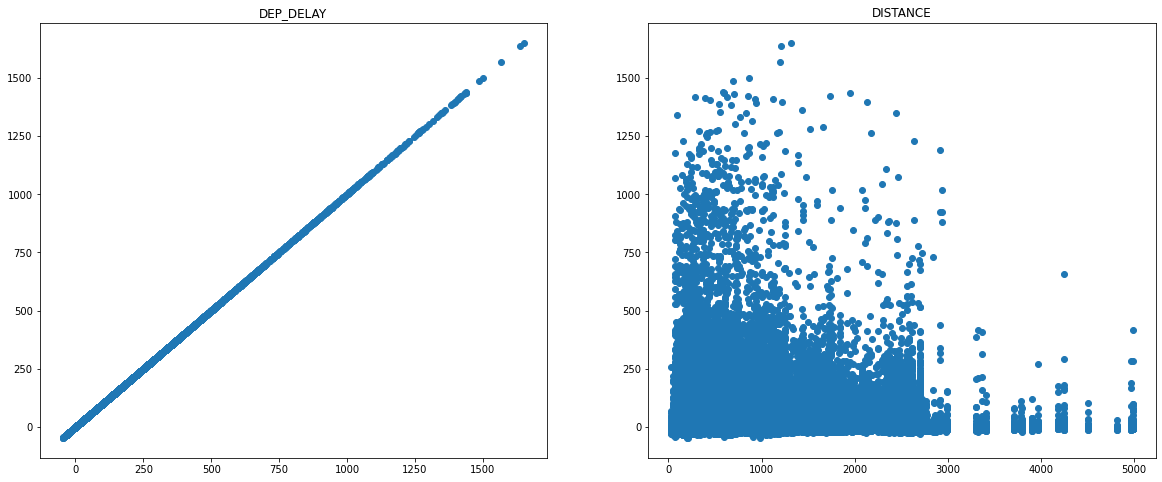

In [ ]:
numerical = ["DEP_DELAY", 'DISTANCE']
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
for i in range(2):
    col_name = numerical[i]
    x_i = data[col_name]
    axs[i].scatter(x_i, y)
    axs[i].set_title(col_name)

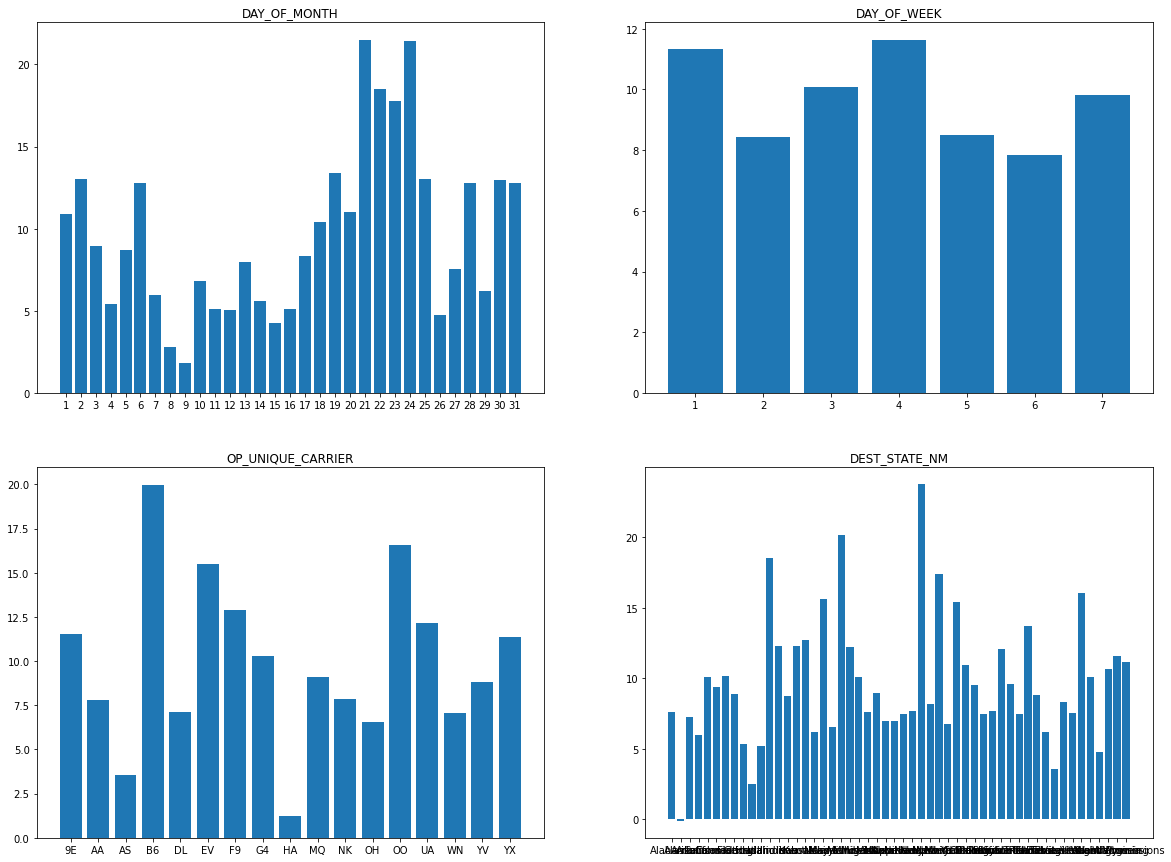

In [ ]:
periodical = ["DAY_OF_MONTH", "DAY_OF_WEEK", "OP_UNIQUE_CARRIER", "DEST_STATE_NM"]
fig, axs = plt.subplots(2, 2, figsize=(20, 15))
for i in range(4):
    ax = axs[i//2, i%2]
    col_name = periodical[i]
    agg = data.copy().groupby(col_name).agg("mean").sort_values(by=[col_name])
    ax.bar(agg.index.astype("str"), agg["DEP_DELAY"])
    ax.set_title(col_name)

In [ ]:
data.head(5)

,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_STATE_NM,DEST_AIRPORT_ID,DEST_STATE_NM,CRS_DEP_TIME,DEP_DELAY,CRS_ELAPSED_TIME,DISTANCE
0,1,2,9E,11953,GNV,Florida,10397,Georgia,360,1.0,83.0,300.0
1,1,2,9E,13487,MSP,Minnesota,11193,Kentucky,844,-5.0,125.0,596.0
2,1,2,9E,11433,DTW,Michigan,11193,Kentucky,740,-5.0,85.0,229.0
3,1,2,9E,15249,TLH,Florida,10397,Georgia,927,-6.0,72.0,223.0
4,1,2,9E,10397,ATL,Georgia,11778,Arkansas,1142,-15.0,123.0,579.0


**Далее будем смотреть, какие признаки можно отбросить**

*   Кодируем категориальные признаки one hot encoding и как доля значения в общем количестве обьектов (процент значений X среди всех значений признака)
*   Смотрим корреляцию



In [ ]:
for_one_hot = ['DAY_OF_WEEK', 'DAY_OF_MONTH']

for col_name in for_one_hot:
    unique_values = data[col_name].unique()
    for val in unique_values:
        mask = data[col_name] == val
        new_col_name = f"{col_name}__{val}"
        data[new_col_name] = 0
        data.loc[mask, new_col_name] = 1
        print(col_name + " OK")
        
data.head()

DAY_OF_WEEK OK
DAY_OF_WEEK OK
DAY_OF_WEEK OK
DAY_OF_WEEK OK
DAY_OF_WEEK OK
DAY_OF_WEEK OK
DAY_OF_WEEK OK
DAY_OF_MONTH OK
DAY_OF_MONTH OK
DAY_OF_MONTH OK
DAY_OF_MONTH OK
DAY_OF_MONTH OK
DAY_OF_MONTH OK
DAY_OF_MONTH OK
DAY_OF_MONTH OK
DAY_OF_MONTH OK
DAY_OF_MONTH OK
DAY_OF_MONTH OK
DAY_OF_MONTH OK
DAY_OF_MONTH OK
DAY_OF_MONTH OK
DAY_OF_MONTH OK
DAY_OF_MONTH OK
DAY_OF_MONTH OK
DAY_OF_MONTH OK
DAY_OF_MONTH OK
DAY_OF_MONTH OK
DAY_OF_MONTH OK
DAY_OF_MONTH OK
DAY_OF_MONTH OK
DAY_OF_MONTH OK
DAY_OF_MONTH OK
DAY_OF_MONTH OK
DAY_OF_MONTH OK
DAY_OF_MONTH OK
DAY_OF_MONTH OK
DAY_OF_MONTH OK
DAY_OF_MONTH OK


,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_STATE_NM,DEST_AIRPORT_ID,DEST_STATE_NM,CRS_DEP_TIME,DEP_DELAY,CRS_ELAPSED_TIME,DISTANCE,DAY_OF_WEEK__2,DAY_OF_WEEK__3,DAY_OF_WEEK__4,DAY_OF_WEEK__5,DAY_OF_WEEK__6,DAY_OF_WEEK__7,DAY_OF_WEEK__1,DAY_OF_MONTH__1,DAY_OF_MONTH__2,DAY_OF_MONTH__3,DAY_OF_MONTH__4,DAY_OF_MONTH__5,DAY_OF_MONTH__6,DAY_OF_MONTH__7,DAY_OF_MONTH__8,DAY_OF_MONTH__9,DAY_OF_MONTH__10,DAY_OF_MONTH__11,DAY_OF_MONTH__12,DAY_OF_MONTH__13,DAY_OF_MONTH__14,DAY_OF_MONTH__15,DAY_OF_MONTH__16,DAY_OF_MONTH__17,DAY_OF_MONTH__18,DAY_OF_MONTH__19,DAY_OF_MONTH__20,DAY_OF_MONTH__21,DAY_OF_MONTH__22,DAY_OF_MONTH__23,DAY_OF_MONTH__24,DAY_OF_MONTH__25,DAY_OF_MONTH__26,DAY_OF_MONTH__27,DAY_OF_MONTH__28,DAY_OF_MONTH__29,DAY_OF_MONTH__30,DAY_OF_MONTH__31
0,1,2,9E,11953,GNV,Florida,10397,Georgia,360,1.0,83.0,300.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,2,9E,13487,MSP,Minnesota,11193,Kentucky,844,-5.0,125.0,596.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,2,9E,11433,DTW,Michigan,11193,Kentucky,740,-5.0,85.0,229.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,2,9E,15249,TLH,Florida,10397,Georgia,927,-6.0,72.0,223.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,2,9E,10397,ATL,Georgia,11778,Arkansas,1142,-15.0,123.0,579.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
data.corr()

,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN_AIRPORT_ID,DEST_AIRPORT_ID,CRS_DEP_TIME,DEP_DELAY,CRS_ELAPSED_TIME,DISTANCE,DAY_OF_WEEK__2,DAY_OF_WEEK__3,DAY_OF_WEEK__4,DAY_OF_WEEK__5,DAY_OF_WEEK__6,DAY_OF_WEEK__7,DAY_OF_WEEK__1,DAY_OF_MONTH__1,DAY_OF_MONTH__2,DAY_OF_MONTH__3,DAY_OF_MONTH__4,DAY_OF_MONTH__5,DAY_OF_MONTH__6,DAY_OF_MONTH__7,DAY_OF_MONTH__8,DAY_OF_MONTH__9,DAY_OF_MONTH__10,DAY_OF_MONTH__11,DAY_OF_MONTH__12,DAY_OF_MONTH__13,DAY_OF_MONTH__14,DAY_OF_MONTH__15,DAY_OF_MONTH__16,DAY_OF_MONTH__17,DAY_OF_MONTH__18,DAY_OF_MONTH__19,DAY_OF_MONTH__20,DAY_OF_MONTH__21,DAY_OF_MONTH__22,DAY_OF_MONTH__23,DAY_OF_MONTH__24,DAY_OF_MONTH__25,DAY_OF_MONTH__26,DAY_OF_MONTH__27,DAY_OF_MONTH__28,DAY_OF_MONTH__29,DAY_OF_MONTH__30,DAY_OF_MONTH__31
DAY_OF_MONTH,1.000000,-0.022425,-0.006891,-0.006681,-0.005915,0.039659,-0.012637,-0.016044,-0.044806,-0.015327,0.051726,-0.056013,-0.024405,0.020857,0.065962,-0.297583,-0.295697,-0.268391,-0.248106,-0.209482,-0.204152,-0.186927,-0.160084,-0.141194,-0.122816,-0.101745,-0.069599,-0.056049,-0.037786,-0.016058,0.004427,0.025746,0.046748,0.055866,0.079368,0.108077,0.123936,0.147868,0.173225,0.195820,0.189105,0.229000,0.250393,0.263178,0.278695,0.308992
DAY_OF_WEEK,-0.022425,1.000000,0.007434,0.007127,0.005297,-0.008911,0.013796,0.017099,-0.415592,-0.193980,0.038212,0.243042,0.388255,0.623316,-0.585811,-0.172640,-0.083894,0.015856,0.114139,0.195940,0.307824,-0.281790,-0.176370,-0.081383,0.016034,0.115271,0.185472,0.296873,-0.280253,-0.175310,-0.080811,0.016015,0.114469,0.175345,0.277883,-0.274519,-0.171073,-0.080167,0.015929,0.115226,0.186777,0.301305,-0.271510,-0.170837,-0.076686,0.015341
ORIGIN_AIRPORT_ID,-0.006891,0.007434,1.000000,0.017145,-0.036182,0.003785,0.060764,0.093341,-0.000233,-0.005711,-0.002642,0.000126,0.005234,0.006714,-0.001990,0.006122,0.001304,0.003040,0.002561,0.004090,-0.000259,-0.000973,-0.002453,-0.002925,-0.001052,-0.000662,0.002489,0.004110,-0.000882,-0.001766,-0.003475,-0.001601,-0.001082,0.000103,0.007936,0.002672,-0.002015,-0.001064,-0.000368,-0.000563,0.003144,0.001412,-0.004621,-0.000321,-0.006002,-0.005631
DEST_AIRPORT_ID,-0.006681,0.007127,0.017145,1.000000,0.027252,0.009946,0.107517,0.093332,-0.000740,-0.005180,-0.002474,0.000046,0.008242,0.003940,-0.002152,0.004731,0.002244,0.002996,0.002928,0.004409,-0.000825,-0.000935,-0.002260,-0.002977,-0.000958,-0.001040,0.003811,0.002931,-0.000760,-0.001797,-0.003532,-0.001476,-0.001468,0.003599,0.005441,0.001678,-0.002066,-0.001023,-0.000560,-0.000317,0.003945,0.000277,-0.004094,-0.000105,-0.005795,-0.005257
CRS_DEP_TIME,-0.005915,0.005297,-0.036182,0.027252,1.000000,0.075412,-0.041310,-0.022959,-0.005624,0.001557,0.004150,0.000626,-0.032391,0.027905,0.001293,0.013309,0.000648,0.000696,0.001741,-0.006295,0.011472,0.001249,-0.004987,0.001291,0.000914,0.000149,-0.017407,0.015778,0.000636,-0.005504,-0.000301,0.001770,-0.002373,-0.022136,0.012464,0.000741,-0.009799,0.003555,-0.000299,0.001662,-0.017107,0.013370,-0.000205,-0.004731,-0.002068,0.005656
DEP_DELAY,0.039659,-0.008911,0.003785,0.009946,0.075412,1.000000,0.015431,0.007615,-0.011757,0.002915,0.017355,-0.010538,-0.013645,0.000528,0.012735,0.004105,0.012838,-0.003266,-0.016977,-0.003703,0.011516,-0.014978,-0.026277,-0.030337,-0.011471,-0.018318,-0.015996,-0.006567,-0.016140,-0.020614,-0.017794,-0.005494,0.002518,0.011558,0.004281,0.044736,0.032125,0.030331,0.045210,0.012816,-0.017170,-0.008252,0.011481,-0.012952,0.011529,0.011264
CRS_ELAPSED_TIME,-0.012637,0.013796,0.060764,0.107517,-0.041310,0.015431,1.000000,0.976044,-0.003975,-0.004348,-0.002008,-0.003405,0.017991,0.005246,-0.006666,0.010615,0.008466,0.006858,0.006022,0.011641,0.005174,-0.003830,-0.005343,-0.005645,-0.003813,-0.004157,0.007995,0.003483,-0.003573,-0.005583,-0.005360,-0.003613,-0.003868,0.007537,0.000135,-0.004075,-0.003922,-0.004922,-0.003242,-0.004375,0.007126,0.000972,-0.001086,-0.003964,-0.001948,-0.000268
DISTANCE,-0.016044,0.017099,0.093341,0.093332,-0.022959,0.007615,0.976044,1.000000,-0.005137,-0.005369,-0.002585

Корреляция для DAY_OF_MONTH низкая + сильно увеличивает количество признаков и разреженность данных, что так себе для лин. регрессии => дропаем DAY_OF_MONTH, DAY_OF_WEEK оставляем   

Корреляция низкая и в случае второго метода кодирования

In [ ]:
data = data.drop(["DAY_OF_MONTH"], axis=1)

In [ ]:
data = data.drop(["DAY_OF_WEEK"], axis=1)

In [ ]:
for i in range(1, 32):
  data = data.drop([f"DAY_OF_MONTH__{i}"], axis=1)

In [ ]:
data.head()

,DAY_OF_WEEK,OP_UNIQUE_CARRIER,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_STATE_NM,DEST_AIRPORT_ID,DEST_STATE_NM,CRS_DEP_TIME,DEP_DELAY,CRS_ELAPSED_TIME,DISTANCE,DAY_OF_WEEK__2,DAY_OF_WEEK__3,DAY_OF_WEEK__4,DAY_OF_WEEK__5,DAY_OF_WEEK__6,DAY_OF_WEEK__7,DAY_OF_WEEK__1
0,2,9E,11953,GNV,Florida,10397,Georgia,360,1.0,83.0,300.0,1,0,0,0,0,0,0
1,2,9E,13487,MSP,Minnesota,11193,Kentucky,844,-5.0,125.0,596.0,1,0,0,0,0,0,0
2,2,9E,11433,DTW,Michigan,11193,Kentucky,740,-5.0,85.0,229.0,1,0,0,0,0,0,0
3,2,9E,15249,TLH,Florida,10397,Georgia,927,-6.0,72.0,223.0,1,0,0,0,0,0,0
4,2,9E,10397,ATL,Georgia,11778,Arkansas,1142,-15.0,123.0,579.0,1,0,0,0,0,0,0


In [ ]:
len(data['ORIGIN_AIRPORT_ID'].unique())

346

In [ ]:
len(data['DEST_AIRPORT_ID'].unique())

346

In [ ]:
len(data['ORIGIN'].unique())

346

In [ ]:
len(data['DEST_STATE_NM'].unique())

52

In [ ]:
len(data['ORIGIN_STATE_NM'].unique())

52

В признаках ORIGIN_AIRPORT_ID, DEST_AIRPORT_ID, ORIGIN, DEST_STATE_NM, ORIGIN_STATE_NM слишком много уникальных значений для one hot encoding.

Для второго метода аналогично (всего 1000 обьектов данных)

=> дропаем их

In [ ]:
data = data.drop(["ORIGIN_AIRPORT_ID", "DEST_AIRPORT_ID", "ORIGIN", "DEST_STATE_NM", "ORIGIN_STATE_NM"], axis=1)

In [ ]:
data.head()

,DAY_OF_WEEK,OP_UNIQUE_CARRIER,CRS_DEP_TIME,DEP_DELAY,CRS_ELAPSED_TIME,DISTANCE,DAY_OF_WEEK__2,DAY_OF_WEEK__3,DAY_OF_WEEK__4,DAY_OF_WEEK__5,DAY_OF_WEEK__6,DAY_OF_WEEK__7,DAY_OF_WEEK__1
0,2,9E,360,1.0,83.0,300.0,1,0,0,0,0,0,0
1,2,9E,844,-5.0,125.0,596.0,1,0,0,0,0,0,0
2,2,9E,740,-5.0,85.0,229.0,1,0,0,0,0,0,0
3,2,9E,927,-6.0,72.0,223.0,1,0,0,0,0,0,0
4,2,9E,1142,-15.0,123.0,579.0,1,0,0,0,0,0,0


In [ ]:
data['OP_UNIQUE_CARRIER'].unique()

array(['9E', 'AA', 'MQ', 'G4', 'OH', 'B6', 'YV', 'EV', 'F9', 'YX', 'HA',
       'NK', 'UA', 'OO', 'WN', 'AS', 'DL'], dtype=object)

In [ ]:
for_one_hot = ['OP_UNIQUE_CARRIER']

for col_name in for_one_hot:
    unique_values = data[col_name].unique()
    for val in unique_values:
        mask = data[col_name] == val
        new_col_name = f"{col_name}__{val}"
        data[new_col_name] = 0
        data.loc[mask, new_col_name] = 1
        print(col_name + " OK")
        
data.head()

OP_UNIQUE_CARRIER OK
OP_UNIQUE_CARRIER OK
OP_UNIQUE_CARRIER OK
OP_UNIQUE_CARRIER OK
OP_UNIQUE_CARRIER OK
OP_UNIQUE_CARRIER OK
OP_UNIQUE_CARRIER OK
OP_UNIQUE_CARRIER OK
OP_UNIQUE_CARRIER OK
OP_UNIQUE_CARRIER OK
OP_UNIQUE_CARRIER OK
OP_UNIQUE_CARRIER OK
OP_UNIQUE_CARRIER OK
OP_UNIQUE_CARRIER OK
OP_UNIQUE_CARRIER OK
OP_UNIQUE_CARRIER OK
OP_UNIQUE_CARRIER OK


,DAY_OF_WEEK,OP_UNIQUE_CARRIER,CRS_DEP_TIME,DEP_DELAY,CRS_ELAPSED_TIME,DISTANCE,DAY_OF_WEEK__2,DAY_OF_WEEK__3,DAY_OF_WEEK__4,DAY_OF_WEEK__5,DAY_OF_WEEK__6,DAY_OF_WEEK__7,DAY_OF_WEEK__1,OP_UNIQUE_CARRIER__9E,OP_UNIQUE_CARRIER__AA,OP_UNIQUE_CARRIER__MQ,OP_UNIQUE_CARRIER__G4,OP_UNIQUE_CARRIER__OH,OP_UNIQUE_CARRIER__B6,OP_UNIQUE_CARRIER__YV,OP_UNIQUE_CARRIER__EV,OP_UNIQUE_CARRIER__F9,OP_UNIQUE_CARRIER__YX,OP_UNIQUE_CARRIER__HA,OP_UNIQUE_CARRIER__NK,OP_UNIQUE_CARRIER__UA,OP_UNIQUE_CARRIER__OO,OP_UNIQUE_CARRIER__WN,OP_UNIQUE_CARRIER__AS,OP_UNIQUE_CARRIER__DL
0,2,9E,360,1.0,83.0,300.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,9E,844,-5.0,125.0,596.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,9E,740,-5.0,85.0,229.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2,9E,927,-6.0,72.0,223.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2,9E,1142,-15.0,123.0,579.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
data.corr()

,DAY_OF_WEEK,CRS_DEP_TIME,DEP_DELAY,CRS_ELAPSED_TIME,DISTANCE,DAY_OF_WEEK__2,DAY_OF_WEEK__3,DAY_OF_WEEK__4,DAY_OF_WEEK__5,DAY_OF_WEEK__6,DAY_OF_WEEK__7,DAY_OF_WEEK__1,OP_UNIQUE_CARRIER__9E,OP_UNIQUE_CARRIER__AA,OP_UNIQUE_CARRIER__MQ,OP_UNIQUE_CARRIER__G4,OP_UNIQUE_CARRIER__OH,OP_UNIQUE_CARRIER__B6,OP_UNIQUE_CARRIER__YV,OP_UNIQUE_CARRIER__EV,OP_UNIQUE_CARRIER__F9,OP_UNIQUE_CARRIER__YX,OP_UNIQUE_CARRIER__HA,OP_UNIQUE_CARRIER__NK,OP_UNIQUE_CARRIER__UA,OP_UNIQUE_CARRIER__OO,OP_UNIQUE_CARRIER__WN,OP_UNIQUE_CARRIER__AS,OP_UNIQUE_CARRIER__DL
DAY_OF_WEEK,1.000000,0.005297,-0.008911,0.013796,0.017099,-0.415592,-0.193980,0.038212,0.243042,0.388255,0.623316,-0.585811,-0.016137,0.003986,0.003667,0.024094,0.000632,-0.003758,0.000709,0.001547,0.009402,-0.006901,0.005378,0.012247,0.004323,-0.000774,-0.004200,0.003889,-0.011379
CRS_DEP_TIME,0.005297,1.000000,0.075412,-0.041310,-0.022959,-0.005624,0.001557,0.004150,0.000626,-0.032391,0.027905,0.001293,-0.000941,-0.007679,0.001007,-0.011760,0.005547,0.015716,0.002907,-0.000499,-0.004206,0.000903,-0.008854,0.012225,-0.011480,-0.000876,0.002046,0.001354,0.002748
DEP_DELAY,-0.008911,0.075412,1.000000,0.015431,0.007615,-0.011757,0.002915,0.017355,-0.010538,-0.013645,0.000528,0.012735,0.006962,-0.015810,-0.002888,0.001181,-0.013334,0.043616,-0.003549,0.017570,0.008360,0.006965,-0.019312,-0.006547,0.014472,0.049153,-0.026895,-0.024617,-0.020906
CRS_ELAPSED_TIME,0.013796,-0.041310,0.015431,1.000000,0.976044,-0.003975,-0.004348,-0.002008,-0.003405,0.017991,0.005246,-0.006666,-0.082434,0.127158,-0.120106,0.000259,-0.130975,0.110687,-0.071602,-0.077331,0.057575,-0.052233,-0.038860,0.054211,0.193634,-0.149355,-0.094918,0.158739,0.069615
DISTANCE,0.017099,-0.022959,0.007615,0.976044,1.000000,-0.005137,-0.005369,-0.002585,-0.004085,0.020935,0.007552,-0.007877,-0.106607,0.123711,-0.128557,0.019700,-0.142225,0.110719,-0.067020,-0.087097,0.058409,-0.075384,-0.011750,0.059829,0.201744,-0.178564,-0.054093,0.169398,0.062785
DAY_OF_WEEK__2,-0.415592,-0.005624,-0.011757,-0.003975,-0.005137,1.000000,-0.192878,-0.196734,-0.174327,-0.149667,-0.164287,-0.172014,0.003447,-0.003189,-0.000654,-0.035231,-0.002939,0.003858,-0.000405,0.002547,-0.005349,0.003617,-0.000120,-0.007084,0.002714,0.000307,0.008731,-0.000029,0.002212
DAY_OF_WEEK__3,-0.193980,0.001557,0.002915,-0.004348,-0.005369,-0.192878,1.000000,-0.201388,-0.178451,-0.153208,-0.168174,-0.176083,0.007526,-0.001963,-0.002678,-0.021355,0.003580,0.001752,0.000326,-0.000486,-0.006976,0.002482,-0.001517,-0.009494,-0.000419,-0.000080,0.004173,-0.001992,0.006107
DAY_OF_WEEK__4,0.038212,0.004150,0.017355,-0.002008,-0.002585,-0.196734,-0.201388,1.000000,-0.182018,-0.156270,-0.171535,-0.179603,0.005115,0.000114,-0.000482,0.013500,0.002164,0.000490,0.000329,-0.002144,0.000545,0.000101,-0.003070,-0.000323,-0.003195,-0.000536,-0.003982,-0.001267,0.001561
DAY_OF_WEEK__5,0.243042,0.000626,-0.010538,-0.003405,-0.004085,-0.174327,-0.178451,-0.182018,1.000000,-0.138472,-0.151998,-0.159147,0.003355,0.000520,0.004472,0.011978,0.001504,0.000378,-0.001579,0.000081,-0.000055,0.000040,-0.000336,-0.000296,-0.002647,0.001084,-0.003662,-0.001355,-0.002784
DAY_OF_WEEK__6,0.388255,-0.032391,-0.013645,0.017991,0.020935,-0.149667,-0.153208,-0.156270,-0.138472,1.000000,-0.130497,-0.136635,-0.019329,0.005302,-0.005503,0.005467,0.003316,-0.000895,0.002007,0.001326,0.009215,-0.005771,0.007227,0.015993,0.006848,-0.001285,-0.003107,0.007260,-0.011051


Корреляция очень маленькая + добавляет большую разреженность в данные => дропаем OP_UNIQUE_CARRIER


In [ ]:
data = data.drop(["OP_UNIQUE_CARRIER"], axis=1)

In [ ]:
for i in ['9E', 'AA', 'MQ', 'G4', 'OH', 'B6', 'YV', 'EV', 'F9', 'YX', 'HA', 'NK', 'UA', 'OO', 'WN', 'AS', 'DL']:
  data = data.drop([f"OP_UNIQUE_CARRIER__{i}"], axis=1)

#Итоговые данные

In [ ]:
data.head()

,CRS_DEP_TIME,DEP_DELAY,CRS_ELAPSED_TIME,DISTANCE,DAY_OF_WEEK__2,DAY_OF_WEEK__3,DAY_OF_WEEK__4,DAY_OF_WEEK__5,DAY_OF_WEEK__6,DAY_OF_WEEK__7,DAY_OF_WEEK__1
0,360,1.0,83.0,300.0,1,0,0,0,0,0,0
1,844,-5.0,125.0,596.0,1,0,0,0,0,0,0
2,740,-5.0,85.0,229.0,1,0,0,0,0,0,0
3,927,-6.0,72.0,223.0,1,0,0,0,0,0,0
4,1142,-15.0,123.0,579.0,1,0,0,0,0,0,0


In [ ]:
X = data.drop(columns=['DEP_DELAY'])
X = X.values.tolist()

In [ ]:
# Для тестов целевую переменную в X
# X = data[['DEP_DELAY', 'AIR_TIME']]
# X = X.values.tolist()

# Алгебраические операции с матрицами

In [ ]:
# Matrix * vector
def multiply_2_vector(matrix, vector):
    assert len(matrix[0]) == len(vector)
    string_size = len(matrix[0])
    result = []
    for i in range(len(matrix)): # i - string
        element = 0
        for j in range(string_size):  # [i][j] - element
            element += matrix[i][j] * vector[j]
        result.append(element)
    return result

# Matrix * vector by string:
#
# for all i:
#     for all j:
#         A[i][j] * x[i]
def multiply_by_string(matrix, vector):
    assert len(matrix) == len(vector)
    result = []
    string_size = len(matrix[0])
    for i in range(len(matrix)): # i - string
        result_string = []
        for j in range(string_size):
            result_string.append(matrix[i][j] * vector[i])
        result.append(result_string)
    return result

# Matrix * Matrix
def multiply_2_matrix(M1, M2):
    assert len(M1[0]) == len(M2)
    result = []
    for i in range(len(M1)): # i - M1 str
        result_vector = []
        for j in range(len(M2[0])): # j - M2 col
            element = 0
            for k in range(len(M1[0])): # k - M1 col, M2 - str
                element += M1[i][k] * M2[k][j]
                print(M1[i][k], M2[k][j])
            result_vector.append(element)
        result.append(result_vector)
    return result

# Метрики

In [ ]:
def mse(y_true, y_pred):
    assert len(y_true) == len(y_pred)
    mse = 0
    for i in range(len(y_true)):
        mse += (y_true[i] - y_pred[i]) ** 2
    mse /= len(y_true)
    return mse

# http://www.machinelearning.ru/wiki/index.php?title=%D0%9A%D0%BE%D1%8D%D1%84%D1%84%D0%B8%D1%86%D0%B8%D0%B5%D0%BD%D1%82_%D0%B4%D0%B5%D1%82%D0%B5%D1%80%D0%BC%D0%B8%D0%BD%D0%B0%D1%86%D0%B8%D0%B8
def r2(y_true, y_pred):
    assert len(y_true) == len(y_pred)
    # сумма квадратов регрессионных остатков
    RSS = 0
    for i in range(len(y_true)):
        RSS += (y_true[i] - y_pred[i]) ** 2
    # выборочное среднее
    y_true_mean = sum(y_true) / len(y_true)
    # общая дисперсия
    TSS = 0
    for i in range(len(y_true)):
        TSS += (y_true[i] - y_true_mean) ** 2
    # Коэффициент детерминации
    R2 = 1 - RSS / TSS
    return R2

def r2_inverse(y_true, y_pred):
    assert len(y_true) == len(y_pred)
    # сумма квадратов регрессионных остатков
    RSS = 0
    for i in range(len(y_true)):
        RSS += (y_true[i] - y_pred[i]) ** 2
    # выборочное среднее
    y_true_mean = sum(y_true) / len(y_true)
    # общая дисперсия
    TSS = 0
    for i in range(len(y_true)):
        TSS += (y_true[i] - y_true_mean) ** 2
    # Коэффициент детерминации
    R2 = RSS / TSS
    return R2

# Нормализация данных

In [ ]:
#класс для нормировки данных
class scaler():
    def __init__(self):
        self.mean = None
        self.sigma = None
    
    def fit_transform(self, X):
        n, m = len(X), len(X[0])
        if self.mean is None or self.sigma is None:
            self.mean = []
            self.sigma = []
            f = False
        else:
            f = True
        
        for i in range(m):
            mean = 0
            for j in range(n):
                mean += X[j][i]
            if f:
                self.mean[i] = self.mean[i]*0.5 + 0.5*mean/n
            else:
                self.mean.append(mean/n)
        
        for i in range(m):
            sigma = 0
            for j in range(n):
                 sigma += (X[j][i] - self.mean[i])**2
            if f:
                self.sigma[i] = self.sigma[i]*0.5 + 0.5*(sigma/n)**0.5
            else:
                self.sigma.append((sigma/n)**0.5)
        
        for i in range(m):
            for j in range(n):
                X[j][i] = (X[j][i] - self.mean[i])/self.sigma[i]
    
        return X
        
    def transform(self, X):
        assert self.mean or self.sigma 
        n, m = len(X), len(X[0])
        for i in range(m):
            for j in range(n):
                X[j][i] = (X[j][i] - self.mean[i])/self.sigma[i]
        return X
    def get_params(self):
        print(self.mean, self.sigma)

In [ ]:
scal = scaler()
X = scal.fit_transform(X)

# Батчи

In [ ]:
def get_batch(X, y, n=128):
    assert len(X) >= n and len(y) >= n
    assert len(X) == len(y)
    dataset = []
    for x_val, y_val in zip(X,y):
        dataset.append(x_val + [y_val,])
    random.shuffle(dataset)
    while len(dataset) != 0:
        batch = []
        batch_size = min((n, len(dataset)))
        for i in range(batch_size):
            batch.append(dataset[i])
        
        x_batch = []
        y_batch = []
        for i in batch:
            x_batch.append(i[:-1])
            y_batch.append(i[-1])
        yield (x_batch, y_batch)
        dataset = dataset[n:]

# Линейная регрессия

In [ ]:
class LinearRegression():
    def __init__(self, optimizer = 'sgd', r1=0, r2=0):
      self.w = None
      self.optimizer = optimizer
      self.r1 = r1
      self.r2 = r2 
      self.f = True
      self.save_weights = []
        
    def predict(self, X):
      if len(X[0]) == len(self.w):
        return  multiply_2_vector(X, self.w)
      else:
        # print(len(X[0]), len(self.w))
        # print(X[0])
        X_train = copy.deepcopy(X)
        for i in range(len(X_train)):
          X_train[i].append(1)
        return multiply_2_vector(X_train, self.w)

    def fit(self, X, y, loss_func = mse, lr=0.1, max_iter=200, batch_size=128):
      n, m = len(X), len(X[0])
      X_train = copy.deepcopy(X)
      for i in range(len(X_train)):
        X_train[i].append(1)
          
      if self.w is None:
        self.w = []
        for i in range(m+1):
          self.w.append(1) #(random.random())
      # self.cache = []
      # for i in range(len(self.w)):
      #   self.cache.append(0)
      
      self.losses = []
      for iter_num in range(max_iter):
        # print('X: ', X[0])
        y_pred = self.predict(X_train)
        self.losses.append(loss_func(y, y_pred))
        self.save_weights.append(self.get_weights())
        if self.optimizer == 'sgd':
          self.sgd_step(X_train, y, y_pred, lr)
        if self.optimizer == 'adagrad':
          if self.f:
            self.cache = []
            self.f = False
            for i in range(len(self.w)):
              self.cache.append(0)
          self.adagrad_step(X_train, y, y_pred, lr)

        if self.optimizer == 'rmsprop':
          if self.f:
            self.cache = []
            self.f = False
            for i in range(len(self.w)):
              self.cache.append(0)
          self.rmsprop_step(X_train, y, y_pred, lr)

        if self.optimizer == 'adam':
          if self.f:
            self.cache = []
            self.velocity = []
            self.f = False
            for i in range(len(self.w)):
              self.cache.append(0)
              self.velocity.append(0)
          self.rmsprop_step(X_train, y, y_pred, lr)


        print(f'iter_num: {iter_num}\tmse: {mse(y, y_pred)},r2: {r2(y, y_pred)} ,r2_inverse: {r2_inverse(y, y_pred)}')
        # print(y_pred[:20])

    def sgd_step(self, X, y, y_pred, lr):
      ind = random.randint(0, len(X)-1)
      grad = [(y_pred[ind] - y[ind]) * i for i in X[ind]]
      # По всем данным, закомментить 2 сроки выше
      # grad = list(multiply_by_string(X,[i-j for i, j in zip(y_pred, y)]))
      # grad = list(map(sum, zip(*grad)))
      # grad = [gr/len(X) for gr in grad]

      w_ = copy.deepcopy(self.w)
      w_[-1] = 0
      grad = [gr+self.r2*w for gr, w in zip(grad, self.w)]
      signw = list(map(lambda x: -1 if x < 0 else 1, w_))
      grad = [gr+self.r1*w for gr, w in zip(grad, signw)]
      self.w = [w-lr*gr for w, gr in zip(self.w, grad)]

    def adagrad_step(self, X, y, y_pred, lr):
      grad = list(multiply_by_string(X,[i-j for i, j in zip(y_pred, y)]))
      grad = list(map(sum, zip(*grad)))
      grad = [gr/len(X) for gr in grad]
      for i in range(len(grad)):
        self.cache[i] += grad[i]**2
      grad = [float(g/c) for g, c in zip(grad, self.cache)]
      w_ = copy.deepcopy(self.w)
      w_[-1] = 0
      grad = [gr+self.r2*w for gr, w in zip(grad, self.w)]
      signw = list(map(lambda x: -1 if x < 0 else 1, w_))
      grad = [gr+self.r1*w for gr, w in zip(grad, signw)]
      self.w = [w-lr*gr for w, gr in zip(self.w, grad)]

    def rmsprop_step(self, X, y, y_pred, lr, b=0.5):
      grad = list(multiply_by_string(X,[i-j for i, j in zip(y_pred, y)]))
      grad = list(map(sum, zip(*grad)))
      grad = [gr/len(X) for gr in grad]
      for i in range(len(grad)):
        self.cache[i] = b*self.cache[i] + (1-b)*(grad[i]**2)
      grad = [float(g/c) for g, c in zip(grad, self.cache)]
      w_ = copy.deepcopy(self.w)
      w_[-1] = 0
      grad = [gr+self.r2*w for gr, w in zip(grad, self.w)]
      signw = list(map(lambda x: -1 if x < 0 else 1, w_))
      grad = [gr+self.r1*w for gr, w in zip(grad, signw)]
      self.w = [w-lr*gr for w, gr in zip(self.w, grad)]


    def adam_step(self, X, y, y_pred, lr, b=0.3, alpha=0.3):
      grad = list(multiply_by_string(X,[i-j for i, j in zip(y_pred, y)]))
      grad = list(map(sum, zip(*grad)))
      grad = [gr/len(X) for gr in grad]
      for i in range(len(grad)):
        self.cache[i] = b*self.cache[i] + (1-b)*(grad[i]**2)
        self.velocity[i] = alpha*self.velocity[i] + (1-alpha)*grad[i]
      grad = [float(v/c) for v, c in zip(self.velocity, self.cache)]
      w_ = copy.deepcopy(self.w)
      w_[-1] = 0
      grad = [gr+self.r2*w for gr, w in zip(grad, self.w)]
      signw = list(map(lambda x: -1 if x < 0 else 1, w_))
      grad = [gr+self.r1*w for gr, w in zip(grad, signw)]
      self.w = [w-lr*gr for w, gr in zip(self.w, grad)]


    def get_weights(self):
      return self.w
    
    def get_losses(self):
        return self.losses

    def renewal(self):
        self.w = None
        self.losses = []
        self.f = True
        self.cache = []
        self.velocity = []

In [ ]:
max_iter = 1000
gen = get_batch(X, y, 1000)
X, y = next(gen)
X_train, y_train = X[:800], y[:800]
X_test, y_test = X[800:], y[800:]

In [ ]:
linreg = LinearRegression(optimizer='sgd')
linreg.fit(X_train, y_train, max_iter=max_iter, lr=0.001)

iter_num: 0	mse: 3384.927038048702,r2: -0.040205297521460404 ,r2_inverse: 1.0402052975214604
iter_num: 1	mse: 3384.9761813550176,r2: -0.04022039950947742 ,r2_inverse: 1.0402203995094774
iter_num: 2	mse: 3384.9411142609547,r2: -0.04020962321308974 ,r2_inverse: 1.0402096232130897
iter_num: 3	mse: 3384.6979806797563,r2: -0.04013490702679512 ,r2_inverse: 1.0401349070267951
iter_num: 4	mse: 3384.704901429086,r2: -0.04013703380826916 ,r2_inverse: 1.0401370338082692
iter_num: 5	mse: 3384.6984754959117,r2: -0.04013505908631676 ,r2_inverse: 1.0401350590863168
iter_num: 6	mse: 3383.1463142341004,r2: -0.039658072034898906 ,r2_inverse: 1.039658072034899
iter_num: 7	mse: 3383.1441374505152,r2: -0.03965740309823018 ,r2_inverse: 1.0396574030982302
iter_num: 8	mse: 3383.2225677636425,r2: -0.03968150513241997 ,r2_inverse: 1.03968150513242
iter_num: 9	mse: 3383.227907768123,r2: -0.03968314614296076 ,r2_inverse: 1.0396831461429608
iter_num: 10	mse: 3383.2197301035317,r2: -0.039680633105033 ,r2_inverse: 1

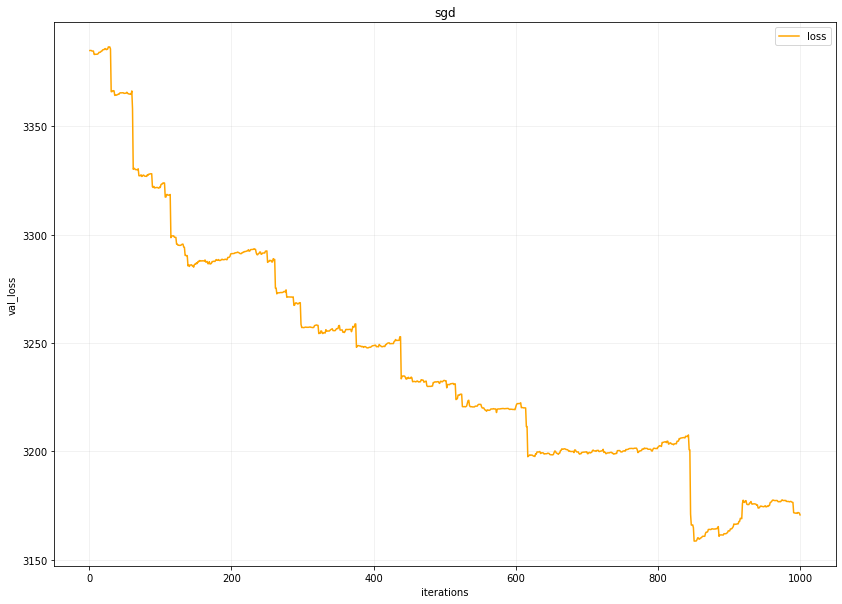

mse on test: 1314.2581129537991, r2 on test: -0.062038794382133444


In [ ]:
xc = [i for i in range(1, max_iter+1)]
val_loss = linreg.get_losses()
plt.figure(figsize=(14,10))
plt.plot(xc, val_loss, label='loss', c='orange')
plt.xlabel('iterations')
plt.ylabel('val_loss')
plt.grid(alpha=0.2)
plt.title('sgd')
plt.legend()
plt.show()
print(f'mse on test: {mse(y_test, linreg.predict(X_test))}, r2 on test: {r2(y_test, linreg.predict(X_test))}')

In [ ]:
linreg = LinearRegression(optimizer='adagrad')
linreg.fit(X_train, y_train, max_iter=max_iter, lr=0.01)

iter_num: 0	mse: 3384.927038048702,r2: -0.040205297521460404 ,r2_inverse: 1.0402052975214604
iter_num: 1	mse: 3384.3615724806546,r2: -0.04003152707594193 ,r2_inverse: 1.040031527075942
iter_num: 2	mse: 3384.0891295446213,r2: -0.039947803975813434 ,r2_inverse: 1.0399478039758134
iter_num: 3	mse: 3383.9089259094967,r2: -0.03989242648206481 ,r2_inverse: 1.0398924264820648
iter_num: 4	mse: 3383.774378723922,r2: -0.03985107944751176 ,r2_inverse: 1.0398510794475118
iter_num: 5	mse: 3383.6670984085217,r2: -0.039818111660866906 ,r2_inverse: 1.039818111660867
iter_num: 6	mse: 3383.577938054282,r2: -0.0397907122304606 ,r2_inverse: 1.0397907122304606
iter_num: 7	mse: 3383.501688184927,r2: -0.03976728025773357 ,r2_inverse: 1.0397672802577336
iter_num: 8	mse: 3383.4351008192375,r2: -0.0397468176215352 ,r2_inverse: 1.0397468176215352
iter_num: 9	mse: 3383.3760148006245,r2: -0.0397286601874518 ,r2_inverse: 1.0397286601874518
iter_num: 10	mse: 3383.32291972932,r2: -0.03971234380195132 ,r2_inverse: 1.0

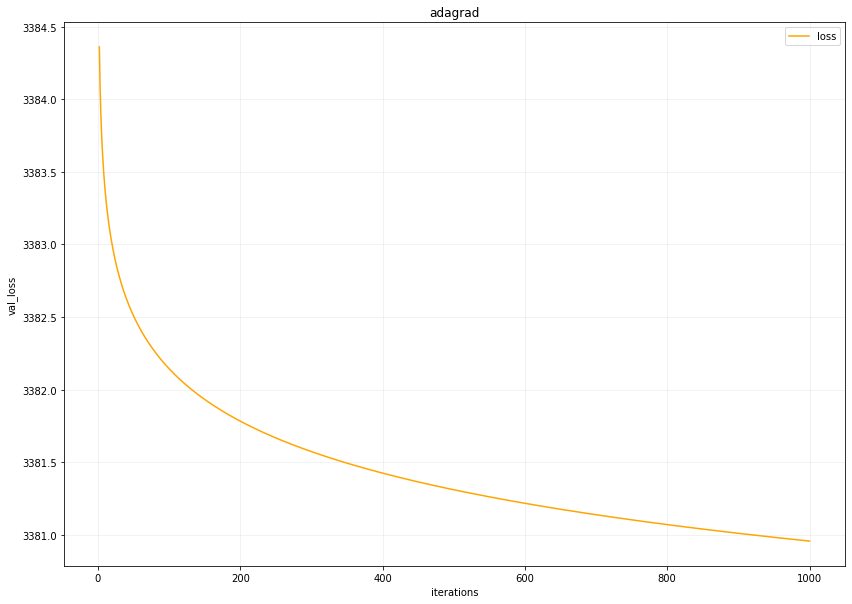

mse on test: 1287.698310263588, r2 on test: -0.04057608431771342


In [ ]:
xc = [i for i in range(1, max_iter+1)]
val_loss = linreg.get_losses()
plt.figure(figsize=(14,10))
plt.plot(xc[1:], val_loss[1:], label='loss', c='orange')
plt.xlabel('iterations')
plt.ylabel('val_loss')
plt.title('adagrad')
plt.grid(alpha=0.2)
plt.legend()
plt.show()
print(f'mse on test: {mse(y_test, linreg.predict(X_test))}, r2 on test: {r2(y_test, linreg.predict(X_test))}')

In [ ]:
linreg = LinearRegression(optimizer='rmsprop')
linreg.fit(X_train, y_train, max_iter=max_iter, lr=0.01)

iter_num: 0	mse: 3384.927038048702,r2: -0.040205297521460404 ,r2_inverse: 1.0402052975214604
iter_num: 1	mse: 3383.8251757765083,r2: -0.03986668964017026 ,r2_inverse: 1.0398666896401703
iter_num: 2	mse: 3383.1132316045882,r2: -0.039647905574562214 ,r2_inverse: 1.0396479055745622
iter_num: 3	mse: 3382.5182011659617,r2: -0.03946504969392195 ,r2_inverse: 1.039465049693922
iter_num: 4	mse: 3381.9653177037717,r2: -0.03929514579353732 ,r2_inverse: 1.0392951457935373
iter_num: 5	mse: 3381.4323299568046,r2: -0.03913135594764783 ,r2_inverse: 1.0391313559476478
iter_num: 6	mse: 3380.92194417847,r2: -0.038974511801692424 ,r2_inverse: 1.0389745118016924
iter_num: 7	mse: 3380.4164604805915,r2: -0.03881917408999791 ,r2_inverse: 1.038819174089998
iter_num: 8	mse: 3379.9045454243005,r2: -0.03866185998914751 ,r2_inverse: 1.0386618599891475
iter_num: 9	mse: 3379.4080798585496,r2: -0.03850929359532973 ,r2_inverse: 1.0385092935953297
iter_num: 10	mse: 3378.949776646702,r2: -0.038368454686994014 ,r2_invers

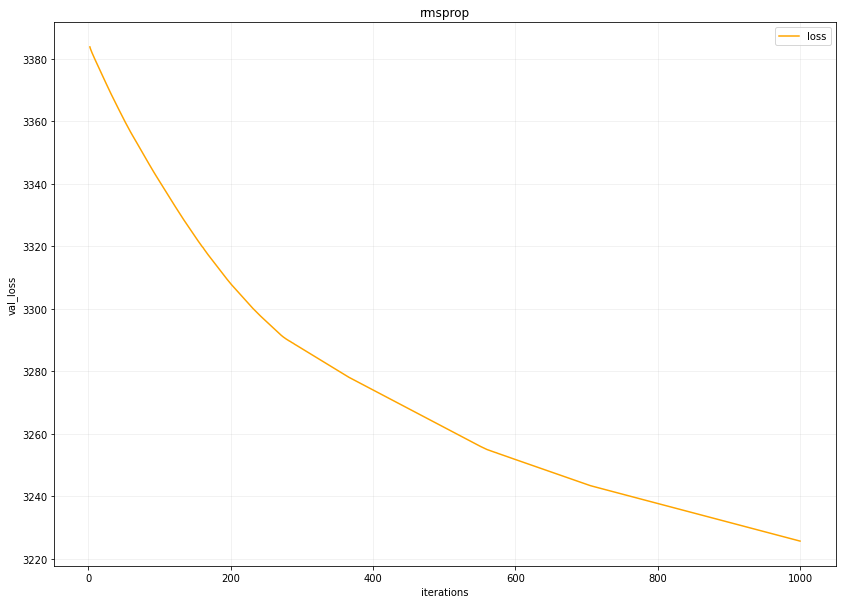

mse on test: 1415.937488475673, r2 on test: -0.1442048775346103


In [ ]:
xc = [i for i in range(1, max_iter+1)]
val_loss = linreg.get_losses()
plt.figure(figsize=(14,10))
plt.plot(xc[1:], val_loss[1:], label='loss', c='orange')
plt.xlabel('iterations')
plt.ylabel('val_loss')
plt.grid(alpha=0.2)
plt.title('rmsprop')
plt.legend()
plt.show()
print(f'mse on test: {mse(y_test, linreg.predict(X_test))}, r2 on test: {r2(y_test, linreg.predict(X_test))}')

In [ ]:
linreg = LinearRegression(optimizer='adam')
linreg.fit(X_train, y_train, max_iter=max_iter, lr=0.01)

iter_num: 0	mse: 3384.927038048702,r2: -0.040205297521460404 ,r2_inverse: 1.0402052975214604
iter_num: 1	mse: 3383.8251757765083,r2: -0.03986668964017026 ,r2_inverse: 1.0398666896401703
iter_num: 2	mse: 3383.1132316045882,r2: -0.039647905574562214 ,r2_inverse: 1.0396479055745622
iter_num: 3	mse: 3382.5182011659617,r2: -0.03946504969392195 ,r2_inverse: 1.039465049693922
iter_num: 4	mse: 3381.9653177037717,r2: -0.03929514579353732 ,r2_inverse: 1.0392951457935373
iter_num: 5	mse: 3381.4323299568046,r2: -0.03913135594764783 ,r2_inverse: 1.0391313559476478
iter_num: 6	mse: 3380.92194417847,r2: -0.038974511801692424 ,r2_inverse: 1.0389745118016924
iter_num: 7	mse: 3380.4164604805915,r2: -0.03881917408999791 ,r2_inverse: 1.038819174089998
iter_num: 8	mse: 3379.9045454243005,r2: -0.03866185998914751 ,r2_inverse: 1.0386618599891475
iter_num: 9	mse: 3379.4080798585496,r2: -0.03850929359532973 ,r2_inverse: 1.0385092935953297
iter_num: 10	mse: 3378.949776646702,r2: -0.038368454686994014 ,r2_invers

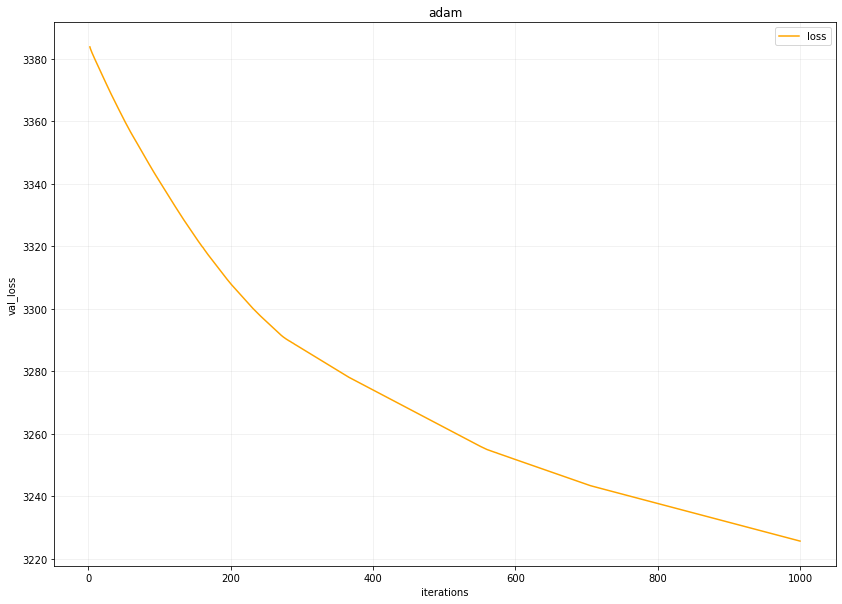

mse on test: 1415.937488475673, r2 on test: -0.1442048775346103


In [ ]:
xc = [i for i in range(1, max_iter+1)]
val_loss = linreg.get_losses()
plt.figure(figsize=(14,10))
plt.plot(xc[1:], val_loss[1:], label='loss', c='orange')
plt.xlabel('iterations')
plt.ylabel('val_loss')
plt.grid(alpha=0.2)
plt.title('adam')
plt.legend()
plt.show()
print(f'mse on test: {mse(y_test, linreg.predict(X_test))}, r2 on test: {r2(y_test, linreg.predict(X_test))}')

In [ ]:
linreg = LinearRegression(r1=0.01, optimizer='adam')
linreg.fit(X_train, y_train, max_iter=max_iter)

iter_num: 0	mse: 3384.927038048702,r2: -0.040205297521460404 ,r2_inverse: 1.0402052975214604
iter_num: 1	mse: 3379.1507144728384,r2: -0.038430203903113025 ,r2_inverse: 1.038430203903113
iter_num: 2	mse: 3372.412296826397,r2: -0.03635945388281692 ,r2_inverse: 1.036359453882817
iter_num: 3	mse: 3367.133932880821,r2: -0.03473738579191954 ,r2_inverse: 1.0347373857919195
iter_num: 4	mse: 3362.396496535326,r2: -0.03328154750416279 ,r2_inverse: 1.0332815475041628
iter_num: 5	mse: 3357.926322667039,r2: -0.03190784033518512 ,r2_inverse: 1.0319078403351851
iter_num: 6	mse: 3353.7684673688277,r2: -0.030630110251519627 ,r2_inverse: 1.0306301102515196
iter_num: 7	mse: 3350.677269801899,r2: -0.02968016951464092 ,r2_inverse: 1.029680169514641
iter_num: 8	mse: 3346.4287359528103,r2: -0.02837457345101968 ,r2_inverse: 1.0283745734510197
iter_num: 9	mse: 3342.310888489361,r2: -0.027109137978491793 ,r2_inverse: 1.0271091379784918
iter_num: 10	mse: 3338.7445507477946,r2: -0.02601318424896437 ,r2_inverse: 1

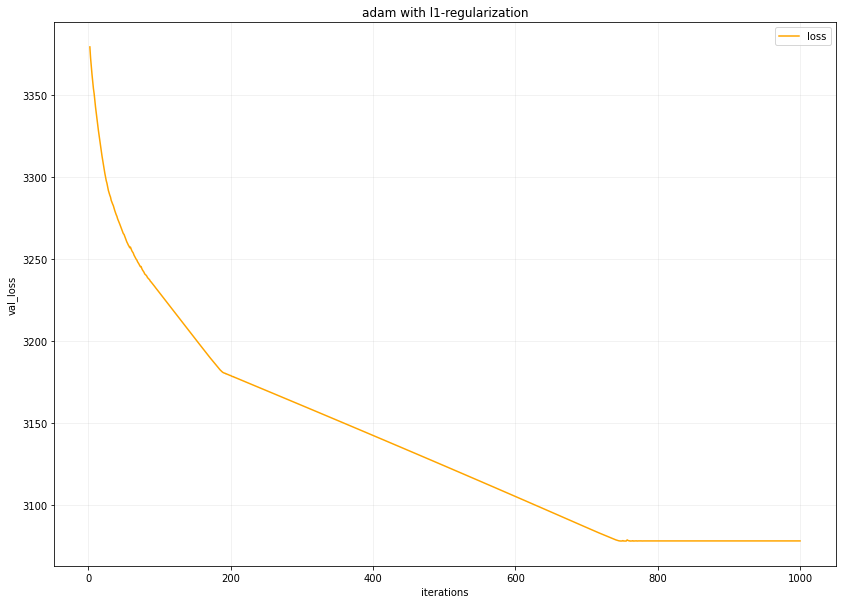

mse on test: 1494.9573260078655, r2 on test: -0.20806001539360097


In [ ]:
xc = [i for i in range(1, max_iter+1)]
val_loss = linreg.get_losses()
plt.figure(figsize=(14,10))
plt.plot(xc[1:], val_loss[1:], label='loss', c='orange')
plt.xlabel('iterations')
plt.ylabel('val_loss')
plt.grid(alpha=0.2)
plt.title('adam with l1-regularization')
plt.legend()
plt.show()
print(f'mse on test: {mse(y_test, linreg.predict(X_test))}, r2 on test: {r2(y_test, linreg.predict(X_test))}')

In [ ]:
linreg = LinearRegression(r2=0.1, optimizer='adam')
linreg.fit(X_train, y_train, max_iter=max_iter, lr=0.01)

iter_num: 0	mse: 3384.927038048702,r2: -0.040205297521460404 ,r2_inverse: 1.0402052975214604
iter_num: 1	mse: 3383.8364333930035,r2: -0.03987014916298559 ,r2_inverse: 1.0398701491629856
iter_num: 2	mse: 3383.1372064315947,r2: -0.039655273160858595 ,r2_inverse: 1.0396552731608586
iter_num: 3	mse: 3382.555200092837,r2: -0.03947641965235982 ,r2_inverse: 1.0394764196523598
iter_num: 4	mse: 3382.0163165752547,r2: -0.03931081800616942 ,r2_inverse: 1.0393108180061694
iter_num: 5	mse: 3381.4976065105693,r2: -0.03915141576467396 ,r2_inverse: 1.039151415764674
iter_num: 6	mse: 3381.003670466298,r2: -0.03899962670567425 ,r2_inverse: 1.0389996267056743
iter_num: 7	mse: 3380.5094550037757,r2: -0.03884775178002475 ,r2_inverse: 1.0388477517800248
iter_num: 8	mse: 3380.0176986157144,r2: -0.03869663254046607 ,r2_inverse: 1.038696632540466
iter_num: 9	mse: 3379.536583609679,r2: -0.03854878345173529 ,r2_inverse: 1.0385487834517353
iter_num: 10	mse: 3379.0881943955605,r2: -0.0384109911653332 ,r2_inverse: 

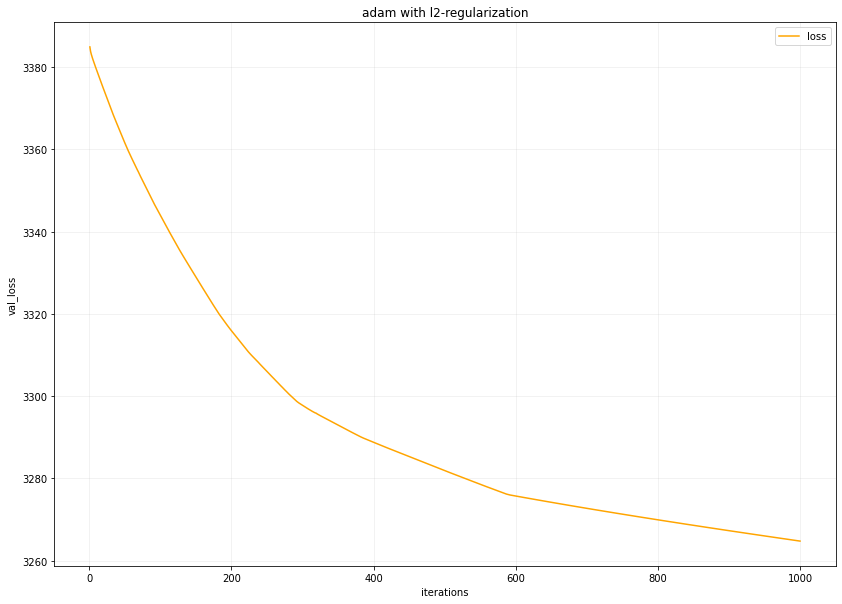

mse on test: 1403.162171757305, r2 on test: -0.13388127227648372


In [ ]:
xc = [i for i in range(1, max_iter+1)]
val_loss = linreg.get_losses()
plt.figure(figsize=(14,10))
plt.plot(xc, val_loss, label='loss', c='orange')
plt.xlabel('iterations')
plt.ylabel('val_loss')
plt.grid(alpha=0.2)
plt.title('adam with l2-regularization')
plt.legend()
plt.show()
print(f'mse on test: {mse(y_test, linreg.predict(X_test))}, r2 on test: {r2(y_test, linreg.predict(X_test))}')

In [ ]:
linreg.get_weights()

[-0.8791367331499245,
 3.048160100010913,
 3.6513141113421383,
 -4.321059908864738,
 -0.6358155851101687,
 -1.8026769293881932,
 2.271527393951692,
 0.5716905332975137,
 2.7132360512989635,
 -1.411027775924961,
 2.050581670340744,
 -3.7583593478218407,
 -2.967700764605618,
 -1.2344364175146694,
 -1.653632745680139,
 -3.353894856107585,
 0.8946926234867021,
 -0.4624869738496568,
 -1.6290627675876834,
 -3.509508446771517,
 -2.470450567501694,
 -1.305383143424196,
 -0.6655871486824678,
 -1.5724709308026639,
 1.3291441143878993,
 -3.3705587333794287,
 1.6137417414779724,
 -1.4947990597141356,
 0.9368199052294949]

# Cross Validation

In [ ]:
def CV(X, y, l1_list = [], l2_list = [], optimizer = 'sgd', iter_count = 3, fold_count=5):
    assert len(X) == len(y)
    # Разбиваем на фолды
    fold_size = math.ceil(len(X) / fold_count)
    fold_list = []
    for i in range(fold_count):
        fold = {
            'X': [],
            'y_true': [],
            'y_pred': [],
            'mse_train': [],
            'mse_test': [],
            'r2_train': [],
            'r2_test': [],
            'loss': [],
            'l1': [],
            'l2': [],
        }
        min_fold_size = min((i + 1)*fold_size, len(X))
        fold['X'] = X[i*fold_size:min_fold_size]
        fold['y_true'] = y[i*fold_size:min_fold_size]
        fold_list.append(fold)
    # Обучаем
    for i in range(fold_count):
        X_train = []
        y_train = []
        X_test = []
        y_test = []
        for j in range(fold_count):
            if i != j:
                X_train += fold_list[j]['X']
                y_train += fold_list[j]['y_true']
            else:
                X_test += fold_list[j]['X']
                y_test += fold_list[j]['y_true']
        for l1 in l1_list:
            for l2 in l2_list:
                print('test_fold_num:', i, ' | l1:', l1, ' | l2:', l2)
                model = LinearRegression(optimizer=optimizer, r1=l1, r2=l2)
                model.fit(X_train, y_train, max_iter=iter_count)
                y_pred_train = model.predict(X_train)
                y_pred_test = model.predict(X_test)
                fold_list[i]['y_pred'].append(y_pred_test)
                # Считаем метрики
                fold_list[i]['mse_train'].append(mse(y_pred_train, y_train))
                fold_list[i]['mse_test'].append(mse(y_pred_test, y_test))
                fold_list[i]['r2_train'].append(r2(y_pred_train, y_train))
                fold_list[i]['r2_test'].append(r2(y_pred_test, y_test))
                fold_list[i]['loss'].append(model.get_losses())
                fold_list[i]['l1'].append(l1)
                fold_list[i]['l2'].append(l2)
    return fold_list

In [ ]:
lst = ['adam']#, 'adagrad', 'rmsprop', 'adam']
iter_num = 500
fold_count = 5
for optimizer in lst:
  cv_res = {
    'optimizer': '',
    'res': None,
  }
  cv_res['optimizer'] = optimizer
  cv_res['res'] = CV(X_train, y_train, l1_list=[0.01, 0.1], l2_list=[0.01, 0.1], iter_count = iter_num, optimizer=optimizer, fold_count=fold_count)

Выходные данные были обрезаны до нескольких последних строк (5000).
iter_num: 9	mse: 3495.9143441198817,r2: -0.03154446514384013 ,r2_inverse: 1.0315444651438401
iter_num: 10	mse: 3492.126719273724,r2: -0.03042684524200623 ,r2_inverse: 1.0304268452420062
iter_num: 11	mse: 3488.5168766577326,r2: -0.029361683798096783 ,r2_inverse: 1.0293616837980968
iter_num: 12	mse: 3484.5624480153047,r2: -0.02819484486059154 ,r2_inverse: 1.0281948448605915
iter_num: 13	mse: 3481.0786615200036,r2: -0.027166878977212372 ,r2_inverse: 1.0271668789772124
iter_num: 14	mse: 3478.131390059351,r2: -0.026297223355464583 ,r2_inverse: 1.0262972233554646
iter_num: 15	mse: 3475.3025555563313,r2: -0.025462515096863703 ,r2_inverse: 1.0254625150968637
iter_num: 16	mse: 3471.985302198898,r2: -0.024483688385592783 ,r2_inverse: 1.0244836883855928
iter_num: 17	mse: 3468.8519109100416,r2: -0.023559114118895774 ,r2_inverse: 1.0235591141188958
iter_num: 18	mse: 3466.1442103085064,r2: -0.022760149014536823 ,r2_inverse: 1.022760

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


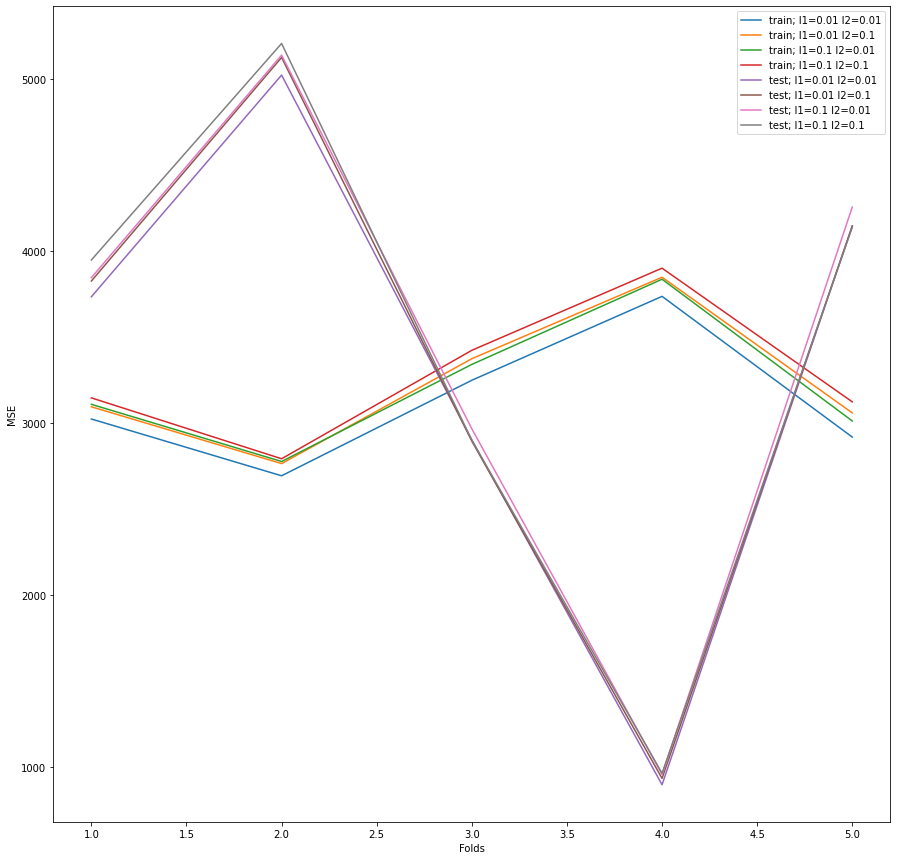

In [ ]:
legends = []
plt.figure(figsize=(15, 15))
for j in range(len(cv_res['res'][0]['l1'])):
  legends.append('train; l1=' + str(cv_res['res'][0]['l1'][j]) + ' l2=' + str(cv_res['res'][0]['l2'][j]))
  plt.plot(range(1, fold_count+1), [cv_res['res'][i]['mse_train'][j] for i in range(fold_count)], '-')
plt.subplot()
for j in range(len(cv_res['res'][0]['l1'])):
  legends.append('test; l1=' + str(cv_res['res'][0]['l1'][j]) + ' l2=' + str(cv_res['res'][0]['l2'][j]))
  plt.plot(range(1, fold_count+1), [cv_res['res'][i]['mse_test'][j] for i in range(fold_count)], '-')
plt.xlabel("Folds")
plt.ylabel("MSE")
plt.legend(tuple(legends))   
plt.show()

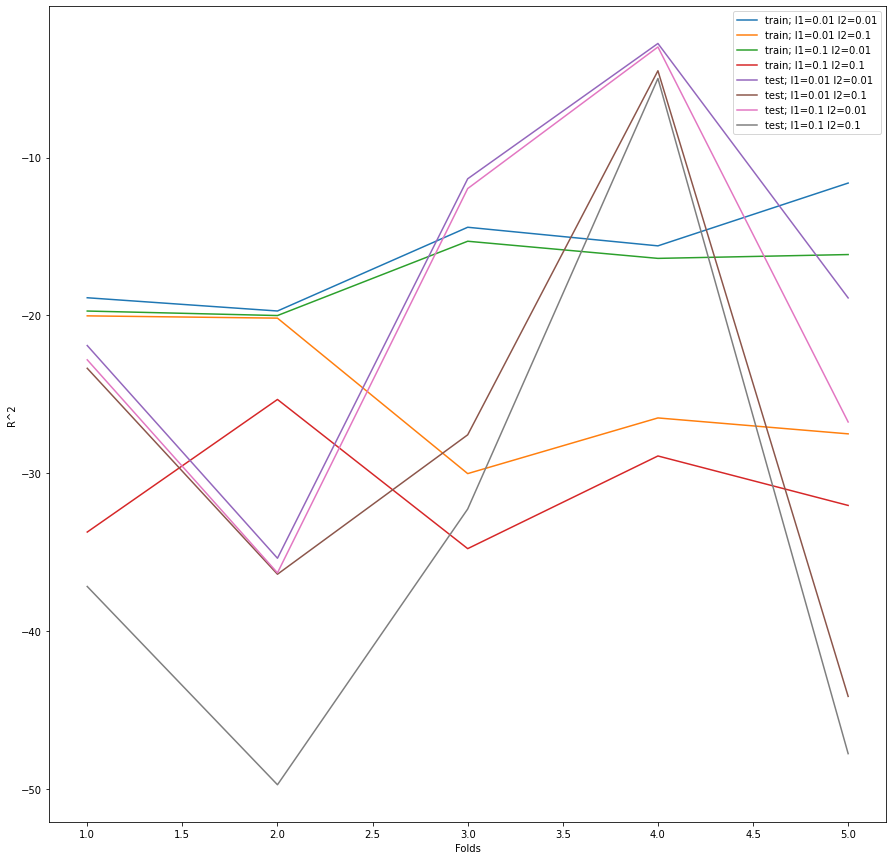

In [ ]:
legends = []
plt.figure(figsize=(15, 15))
for j in range(len(cv_res['res'][0]['l1'])):
  legends.append('train; l1=' + str(cv_res['res'][0]['l1'][j]) + ' l2=' + str(cv_res['res'][0]['l2'][j]))
  plt.plot(range(1, fold_count+1), [cv_res['res'][i]['r2_train'][j] for i in range(fold_count)], '-')
for j in range(len(cv_res['res'][0]['l1'])):
  legends.append('test; l1=' + str(cv_res['res'][0]['l1'][j]) + ' l2=' + str(cv_res['res'][0]['l2'][j]))
  plt.plot(range(1, fold_count+1), [cv_res['res'][i]['r2_test'][j] for i in range(fold_count)], '-')
plt.xlabel("Folds")
plt.ylabel("R^2")
plt.legend(tuple(legends))   
plt.show()

In [ ]:
# Как нам кажется, в среднем лучше себя ведет смешанная регуляризация с коэффициентами l1=0.1 и l2=0.2

# Графики по lambda

In [ ]:
lambdas = np.linspace(1, 100, 100)
w_list = []
loss_list = []
for lm in lambdas:
  model = LinearRegression(r1=math.log(lm, 10), optimizer = 'rmsprop')
  model.fit(X_train, y_train, lr=0.01, max_iter=100)
  w_list.append(model.get_weights()[:-1])
  loss_list.append(mse(y_train, model.predict(X_train)))

Выходные данные были обрезаны до нескольких последних строк (5000).
iter_num: 0	mse: 1678.6346325896372,r2: -0.054491003491278 ,r2_inverse: 1.054491003491278
iter_num: 1	mse: 1678.36728590338,r2: -0.0543230606465408 ,r2_inverse: 1.0543230606465408
iter_num: 2	mse: 1678.2682756917397,r2: -0.054260864040202694 ,r2_inverse: 1.0542608640402027
iter_num: 3	mse: 1678.2213950352461,r2: -0.05423141437346146 ,r2_inverse: 1.0542314143734615
iter_num: 4	mse: 1678.1991901398496,r2: -0.05421746561893537 ,r2_inverse: 1.0542174656189354
iter_num: 5	mse: 1678.1918507281714,r2: -0.05421285511976204 ,r2_inverse: 1.054212855119762
iter_num: 6	mse: 1678.1954374772874,r2: -0.05421510825728304 ,r2_inverse: 1.054215108257283
iter_num: 7	mse: 1678.2085621889325,r2: -0.05422335298790193 ,r2_inverse: 1.054223352987902
iter_num: 8	mse: 1678.2312342798757,r2: -0.05423759522707994 ,r2_inverse: 1.05423759522708
iter_num: 9	mse: 1678.2642398319915,r2: -0.05425832877867931 ,r2_inverse: 1.0542583287786793
iter_num: 10

In [ ]:
data.head()

,CRS_DEP_TIME,DEP_DELAY,CRS_ELAPSED_TIME,DISTANCE,DAY_OF_WEEK__2,DAY_OF_WEEK__3,DAY_OF_WEEK__4,DAY_OF_WEEK__5,DAY_OF_WEEK__6,DAY_OF_WEEK__7,DAY_OF_WEEK__1
0,360,1.0,83.0,300.0,1,0,0,0,0,0,0
1,844,-5.0,125.0,596.0,1,0,0,0,0,0,0
2,740,-5.0,85.0,229.0,1,0,0,0,0,0,0
3,927,-6.0,72.0,223.0,1,0,0,0,0,0,0
4,1142,-15.0,123.0,579.0,1,0,0,0,0,0,0


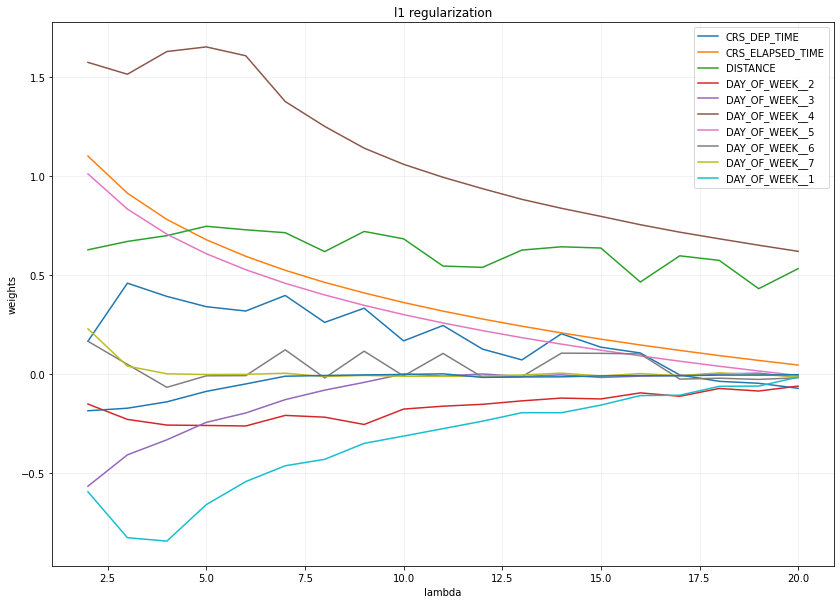

In [ ]:
xc = lambdas
plt.figure(figsize=(14,10))
plt.plot(xc[1:20], w_list[1:20])
plt.xlabel('lambda')
plt.ylabel('weights')
plt.legend(tuple(['CRS_DEP_TIME', 'CRS_ELAPSED_TIME',
       'DISTANCE', 'DAY_OF_WEEK__2', 'DAY_OF_WEEK__3', 'DAY_OF_WEEK__4',
       'DAY_OF_WEEK__5', 'DAY_OF_WEEK__6', 'DAY_OF_WEEK__7', 'DAY_OF_WEEK__1']))
plt.grid(alpha=0.2)
plt.title('l1 regularization')
plt.show()

В целом по результатам можно было бы выкинуть некоторые из признаков (которые зануляются), но их и так немного :)

In [ ]:
lambdas = np.linspace(1, 100, 100)
w_list = []
loss_list = []
for lm in lambdas:
  model = LinearRegression(r2=math.log(lm, 10), optimizer = 'rmsprop')
  model.fit(X_train, y_train, lr=0.01, max_iter=100)
  w_list.append(model.get_weights()[:-1])
  loss_list.append(mse(y_train, model.predict(X_train)))

Выходные данные были обрезаны до нескольких последних строк (5000).
iter_num: 0	mse: 1678.6346325896372,r2: -0.054491003491278 ,r2_inverse: 1.054491003491278
iter_num: 1	mse: 1678.36728590338,r2: -0.0543230606465408 ,r2_inverse: 1.0543230606465408
iter_num: 2	mse: 1678.272480263836,r2: -0.0542635052840823 ,r2_inverse: 1.0542635052840823
iter_num: 3	mse: 1678.2307546993243,r2: -0.054237293962369426 ,r2_inverse: 1.0542372939623694
iter_num: 4	mse: 1678.2134801636648,r2: -0.054226442379726514 ,r2_inverse: 1.0542264423797265
iter_num: 5	mse: 1678.2101473448606,r2: -0.054224348757101914 ,r2_inverse: 1.054224348757102
iter_num: 6	mse: 1678.2162638593625,r2: -0.05422819105213739 ,r2_inverse: 1.0542281910521374
iter_num: 7	mse: 1678.2299049151104,r2: -0.05423676014173262 ,r2_inverse: 1.0542367601417326
iter_num: 8	mse: 1678.2504952466284,r2: -0.05424969465346208 ,r2_inverse: 1.054249694653462
iter_num: 9	mse: 1678.278321575226,r2: -0.05426717470099396 ,r2_inverse: 1.054267174700994
iter_num: 1

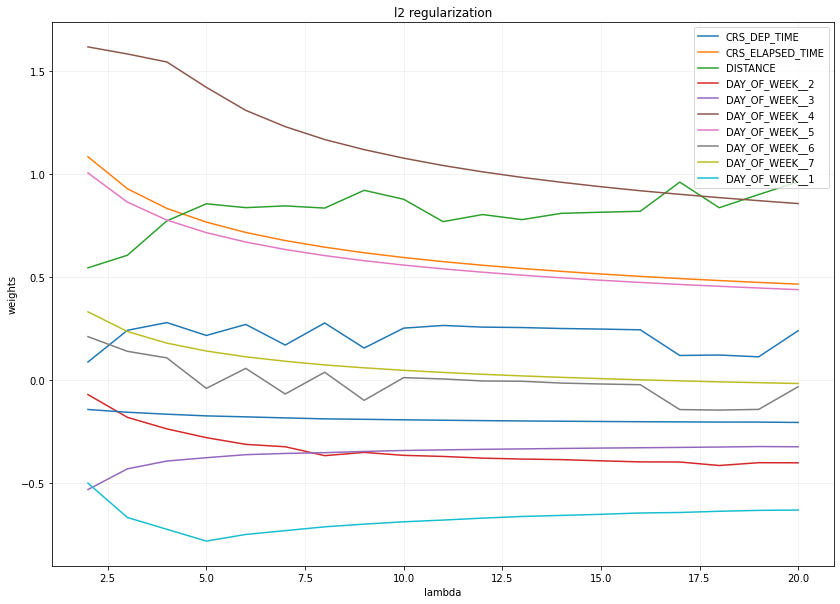

In [ ]:
xc = lambdas
plt.figure(figsize=(14,10))
plt.plot(xc[1:20], w_list[1:20])
plt.xlabel('lambda')
plt.ylabel('weights')
plt.legend(tuple(['CRS_DEP_TIME', 'CRS_ELAPSED_TIME',
       'DISTANCE', 'DAY_OF_WEEK__2', 'DAY_OF_WEEK__3', 'DAY_OF_WEEK__4',
       'DAY_OF_WEEK__5', 'DAY_OF_WEEK__6', 'DAY_OF_WEEK__7', 'DAY_OF_WEEK__1']))
plt.grid(alpha=0.2)
plt.title('l2 regularization')
plt.show()

# Ответы на вопросы

**SGD**

SGD стал нормально работать после изменения lr на значение - 0.001 (ставили слишком большое значение)

**Отрицательный коэффициент детерминации**
https://ru.wikipedia.org/wiki/%D0%9A%D0%BE%D1%8D%D1%84%D1%84%D0%B8%D1%86%D0%B8%D0%B5%D0%BD%D1%82_%D0%B4%D0%B5%D1%82%D0%B5%D1%80%D0%BC%D0%B8%D0%BD%D0%B0%D1%86%D0%B8%D0%B8

В статье на википедии говорится о том, что в общем случае коэффициент детерминации может быть и отрицательным. Это говорит о крайней неадекватности модели: простое среднее приближает лучше (собственно, модель не обучалась из-за сильно высокого learning rate)

Далее идет сравние с моделью из коробки:


**Сравнение с моделью из коробки**

In [ ]:
import numpy as np
from sklearn import linear_model

In [ ]:
X_train_np = np.array(X_train)
y_train_np = np.array(y_train)
X_test_np = np.array(X_test)
y_test_np = np.array(y_test)

In [ ]:
reg = linear_model.LinearRegression()
reg.fit(X_train_np, y_train_np)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
print(print(f'mse on test: {mse(y_test_np, reg.predict(X_test_np))}, r2 on test: {r2(y_test_np, reg.predict(X_test_np))}, r2_inverse on test: {r2_inverse(y_test_np, reg.predict(X_test_np))}'))

mse on test: 1499.0372193840979, r2 on test: -0.2113569362950538, r2_inverse on test: 1.2113569362950538
None


In [ ]:
sgd_reg = linear_model.SGDRegressor(learning_rate='constant', n_iter_no_change=100, verbose=1)
sgd_reg.fit(X_train_np, y_train_np)

-- Epoch 1
Norm: 14.27, NNZs: 28, Bias: 11.253824, T: 800, Avg. loss: 1866.671821
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 14.54, NNZs: 28, Bias: 9.436928, T: 1600, Avg. loss: 1820.699549
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 18.65, NNZs: 28, Bias: 9.519277, T: 2400, Avg. loss: 1841.114996
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 14.46, NNZs: 28, Bias: 9.111889, T: 3200, Avg. loss: 1850.559636
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 27.80, NNZs: 28, Bias: 11.318278, T: 4000, Avg. loss: 1828.100879
Total training time: 0.00 seconds.
-- Epoch 6
Norm: 37.83, NNZs: 28, Bias: 18.949110, T: 4800, Avg. loss: 1842.780123
Total training time: 0.00 seconds.
-- Epoch 7
Norm: 26.14, NNZs: 28, Bias: 17.055412, T: 5600, Avg. loss: 1815.925203
Total training time: 0.00 seconds.
-- Epoch 8
Norm: 29.53, NNZs: 28, Bias: 15.930971, T: 6400, Avg. loss: 1854.831688
Total training time: 0.00 seconds.
-- Epoch 9
Norm: 16.64, NNZs: 28, Bias: 6.163403, T: 7200, A

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='constant', loss='squared_loss', max_iter=1000,
             n_iter_no_change=100, penalty='l2', power_t=0.25,
             random_state=None, shuffle=True, tol=0.001,
             validation_fraction=0.1, verbose=1, warm_start=False)

In [ ]:
print(print(f'mse on test: {mse(y_test_np, reg.predict(X_test_np))}, r2 on test: {r2(y_test_np, sgd_reg.predict(X_test_np))}, r2_inverse on test: {r2_inverse(y_test_np, sgd_reg.predict(X_test_np))}'))

mse on test: 1499.0372193840979, r2 on test: -0.20822383084300644, r2_inverse on test: 1.2082238308430064
None


Наши модели получают mse меньше чем методы из коробки. Методы из sklearn также показывают отрицательный коэффициент детерминации r2. 
Нам не удалось достигнуть приемлемой точности модели, как и моделям из sklearn. Как нам кажется, это связано с данными, которые не удовлетворяют условиям линейной регрессии.
